In [1]:
import sys,os
sys.path.append(os.getcwd()+'/..')
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import expm
from scipy.spatial.transform import Rotation as rot
from RobotController import RobotStateEstimate as rse

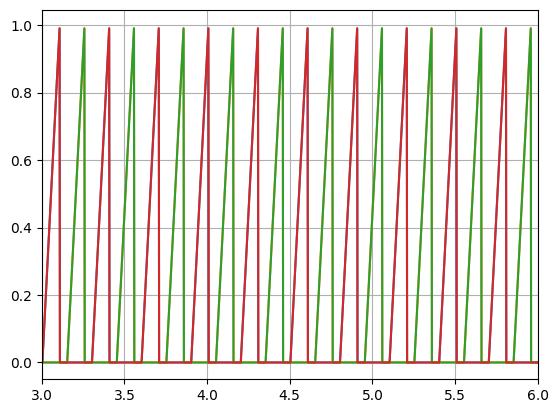

In [2]:
# read test data from log file
timestep = 2
dt = 0.001 * timestep
data = np.loadtxt('log1.csv', delimiter=',', dtype=np.float64)
cnt = data[:, 0]
time = cnt * dt
snsr_acc =        data[:, 1:4]
snsr_gyr =       data[:, 4:7]
snsr_orn =       data[:, 7:11]
jnt_act_pos =     data[:, 11:23]
jnt_act_vel =     data[:, 23:35]
jnt_ref_trq =     data[:, 35:47]
support_state =   data[:, 47:51]
support_phase =   data[:, 51:55]
body_act_pos =    data[:, 55:58]
body_act_vel =    data[:, 58:61]
body_act_orn =    data[:, 61:65]
body_act_angvel = data[:, 65:68]

plt.plot(time, support_phase)
plt.xlim([3,6])
plt.grid(True)
# plt.show()


In [3]:
# add noise to raw sensor data
snsr_acc += np.random.normal(0.2, 1.75e-3 * 33, snsr_acc.shape)
snsr_gyr += np.random.normal(0.02, 0.01 / 57.3 * 33, snsr_gyr.shape)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.96326711e-04 -9.99999683e-01]
 [ 0.00000000e+00  9.99999683e-01  7.96326711e-04]]
[0.70682518 0.         0.         0.70738827]
[-0.70682518 -0.         -0.          0.70738827]


(0.0, 10.0)

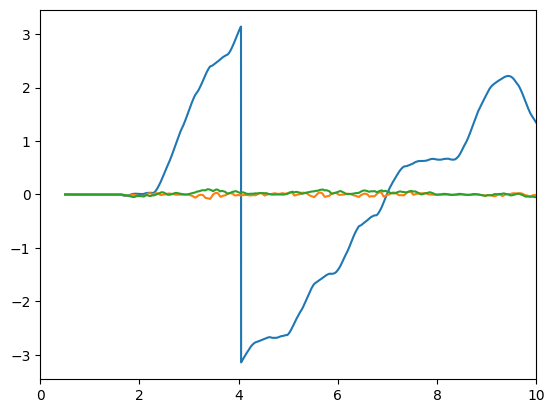

In [4]:
# Rotate sensor data from IMU local frame to body frame/world frame
# translation 0.000000 0.000000 0.000000
# rotation 1.000000 0.000000 0.000000 1.570000
pos_bs = np.array([0, 0, 0])  # bs means ___ of sensor wrt body cs
rotaxis_bs = np.array([1, 0, 0])
rotangle_bs = 1.57
R_bs = rot.from_rotvec(rotaxis_bs * rotangle_bs).as_matrix()
q_bs = rot.from_rotvec(rotaxis_bs * rotangle_bs).as_quat()
q_sb = rot.from_rotvec(rotaxis_bs * -rotangle_bs).as_quat()
R_sb = R_bs.T

print(R_bs)
print(q_bs)
print(q_sb)

body_orn_w = snsr_orn.copy()
body_orn_b = snsr_orn.copy()
body_gyr_b = snsr_gyr.copy()
body_gyr_w = snsr_gyr.copy()
body_acc_b = snsr_acc.copy()
body_acc_w = snsr_acc.copy()

rpy_wb = np.zeros((time.size, 3))

for i in range(time.size):
    q_ws = snsr_orn[i, :] # quat of sensor wrt world cs
    q_wb = rse.quat_prod(q_ws, q_sb)  # quat of body wrt world cs
    if q_wb[3] < 0:
        q_wb *= -1
    body_orn_w[i, :] = q_wb
    body_orn_b[i, :] = rse.quat_inv(q_wb)
    R_wb = rot.from_quat(q_wb).as_matrix()
    w_ss = snsr_gyr[i, :]
    w_bb = R_bs @ w_ss
    w_wb = R_wb @ w_bb
    body_gyr_b[i, :] = w_bb
    body_gyr_w[i, :] = w_wb
    a_ss = snsr_acc[i, :]
    a_bb = R_bs @ a_ss
    a_wb = R_wb @ a_bb
    body_acc_b[i, :] = a_bb
    body_acc_w[i, :] = a_wb

    # calculate body RPY angle for read, in yaw, pitch, roll order
    rpy_wb[i, :] = rot.from_quat(q_wb).as_euler('ZYX')


#plt.plot(time, body_acc_w)
plt.plot(time, rpy_wb)
plt.xlim([0,10])


In [5]:
# feed data to state estimator
body_pos_init = body_act_pos[0, :]
body_vel_init = body_act_vel[0, :]
body_orn_init = body_act_orn[0, :]
jnt_pos_init = jnt_act_pos[0, :]

estimator = rse.QuadStateEstimator(dt)
estimator.reset_state(body_pos_init, body_vel_init, body_orn_init, jnt_pos_init)

# total_step = time.size
total_step = time.size
robot_state = np.zeros((total_step, estimator.ns))

for i in range(0, total_step):
    estimator.update(
        body_gyr_b[i, :], 
        body_acc_b[i, :], 
        jnt_act_pos[i, :],
        jnt_act_vel[i, :],
        jnt_ref_trq[i, :],
        support_state[i, :],
        support_phase[i, :] )
    x = estimator.get_results()
    robot_state[i, :] = x



In [6]:
# convert robot orn into rpy for read
est_p_wb = robot_state[:, 0:3]
est_v_wb = robot_state[:, 3:6]
est_q_bw = robot_state[:, 6:10]

est_rpy_wb = np.zeros((total_step, 3))
rpy_real_wb = np.zeros((total_step, 3))

for i in range(total_step):
    est_q_wb_i = rse.quat_inv(est_q_bw[i, :])
    est_rpy_wb[i, :] = rot.from_quat(est_q_wb_i).as_euler('ZYX')
    q_real_wb_i = body_act_orn[i, :]
    rpy_real_wb[i, :] = rot.from_quat(q_real_wb_i).as_euler('ZYX')

[ 3.81368711e-01 -7.58239325e-01  2.78696032e+00 -2.34072159e-02
  3.88274941e-01  4.01470618e-01  2.75950026e-02  1.90996620e-02
  7.18576691e-01  6.94637501e-01  2.42571812e-01 -9.27911987e-01
  2.53995567e+00  5.05048383e-01 -9.35799352e-01  2.49789620e+00
  2.53133338e-01 -5.65989172e-01  2.47503470e+00  5.13682439e-01
 -5.70694233e-01  2.51229470e+00  5.60752868e-05  2.22811323e-05
  2.28752243e-03  2.29692826e-04  2.71188197e-05 -4.24050220e-05]


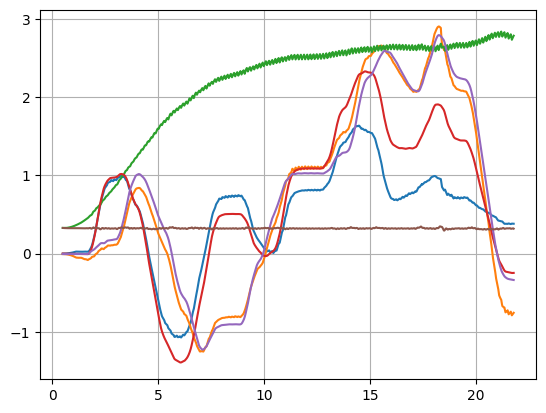

In [7]:
print(x)
tend = total_step
plt.plot(time[0:tend], est_p_wb[0:tend, :])
plt.plot(time[0:tend], body_act_pos[0:tend, :])
#plt.xlim([0.5,0.55])
plt.grid(True)

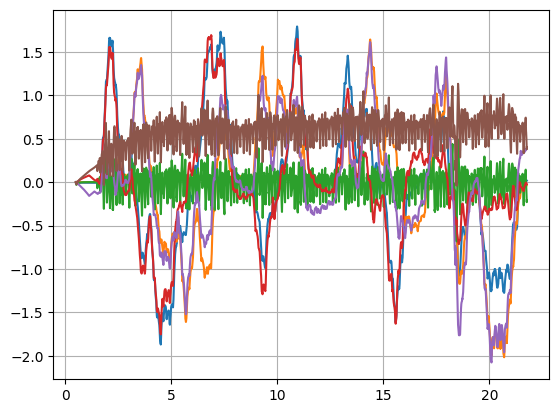

In [10]:
plt.plot(time[0:tend], body_act_vel[0:tend, :])
plt.plot(time[0:tend], est_v_wb[0:tend, :])
#plt.xlim([5,10])
plt.grid(True)

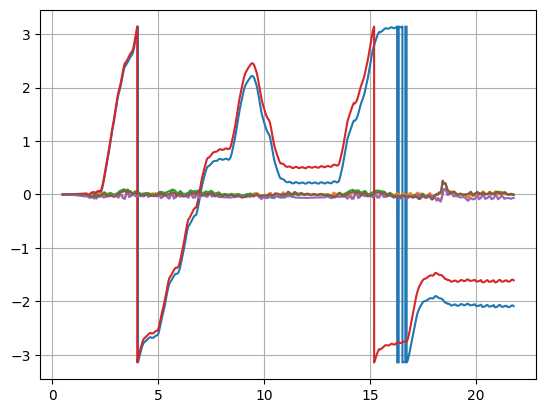

In [9]:
plt.plot(time[0:tend], rpy_real_wb[0:tend, :])
plt.plot(time[0:tend], est_rpy_wb[0:tend, :])
plt.grid(True)